# Amazon Monitoring distribution center

structure

* Introduction
* imports and parameters
* data preparation
* hyper parameter optimization
* model training
* deployment
* testing

### Introduction

This notebook address the following usecase, predict the number of items in a bin. The business problem that we are going train to address is to get the number of items in a bin and helping to manage inventory and orders

The data is provided by Amazon and can be found in the following link: https://registry.opendata.aws/amazon-bin-imagery/

The data and model pipeline are developed in python and deployed in AWS sagemaker. The machine learning solution choice is to finetune a pretrained model using Pytorch framework

### Imports 

In [ ]:
!pip install seaborn

In [2]:
import os
import json
import boto3

import IPython
import tqdm
import shutil
import pandas as pd
import random
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import sagemaker
import boto3
import os
from sagemaker import get_execution_role

In [4]:
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner, IntegerParameter
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.predictor import Predictor as sagemaker_predictor

In [5]:
from sagemaker.debugger import Rule, rule_configs, ProfilerRule, DebuggerHookConfig, CollectionConfig, ProfilerConfig, FrameworkProfile

In [6]:
from PIL import Image
import io

In [47]:
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_ind

### Parameters

In [7]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = get_execution_role() 
print(bucket)
print(role)

sagemaker-us-east-1-326431866350
arn:aws:iam::326431866350:role/service-role/AmazonSageMaker-ExecutionRole-20230904T074611


## Data Preparation

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [15]:
def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in d[k]:
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

In [16]:
download_and_arrange_data()

## Dataset


<b>Data inspection

raw data is down loaded in a file called train_data. Train data contains 5 files (5 labels,1, 2, 3, 4 and 5)

lets inspect the content:

In [25]:
## extracting files and labels for inspection
data_dict = {
    'label':list(),
    'image_name':list(),
}

for label in os.listdir('train_data'):
    for image_name in os.listdir(f'train_data/{label}'):
        data_dict['label'].append(label)
        data_dict['image_name'].append(image_name)
        
data_pd = pd.DataFrame(data_dict)

In [48]:
data_pd.head()

label  image_name
0     4   02573.jpg
1     4  101366.jpg
2     4   04193.jpg
3     4   07028.jpg
4     4   09521.jpg

In [30]:
print('total number of images:', len(data_pd))

total number of images: 10441


ditribution of the data by label:

<AxesSubplot:xlabel='label', ylabel='count'>

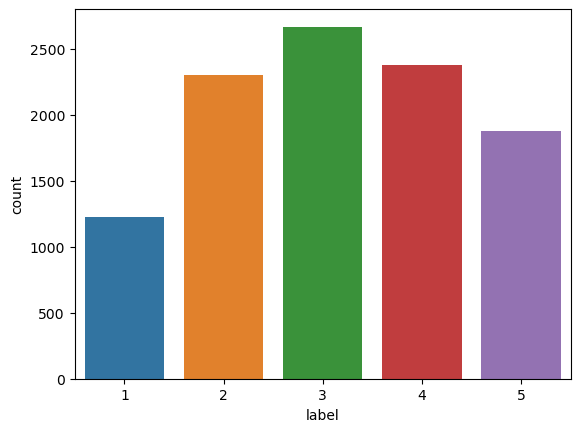

In [41]:
df_plot = data_pd.groupby('label',as_index = False).agg(count = ('image_name','count'))
sns.barplot(data=df_plot, x="label", y="count")

just images with 1 item (label 1) are about 1.3 while the other classes have more images

visual inspection of the classes

In [83]:
def plot_images(data_pd,label):
    data_filter = data_pd[data_pd.label == label]
    data_sample = data_filter.sample(n = 15)
    paths = list()
    for index, row in data_sample.iterrows():
        
        img_path = 'train_data/' + str(row.label) + '/' + str(row.image_name)
        paths.append(img_path)
        
    f, axarr = plt.subplots(3,5, figsize = (15,10))
    i = 0
    for r in range(3):
        for c in range(5):
            axarr[r,c].imshow(mpimg.imread(paths[i]))
            axarr[r,c].axis('off')
            i += 1

    f.suptitle(f'label {label}')
    f.tight_layout()
    plt.show()

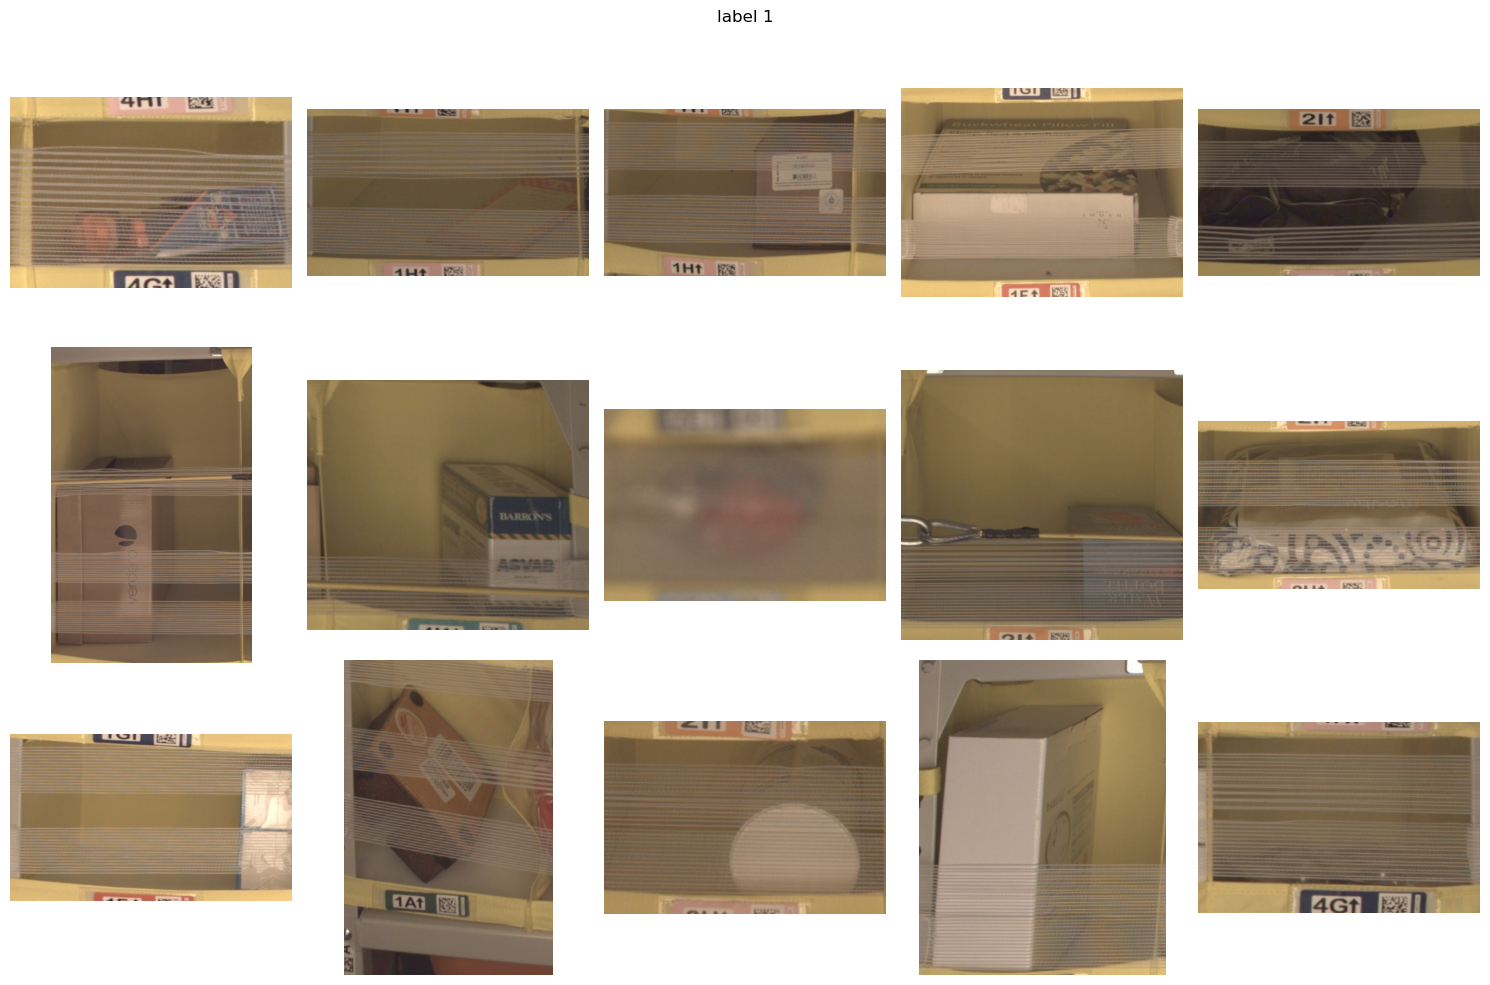

In [84]:
plot_images(data_pd,'1')

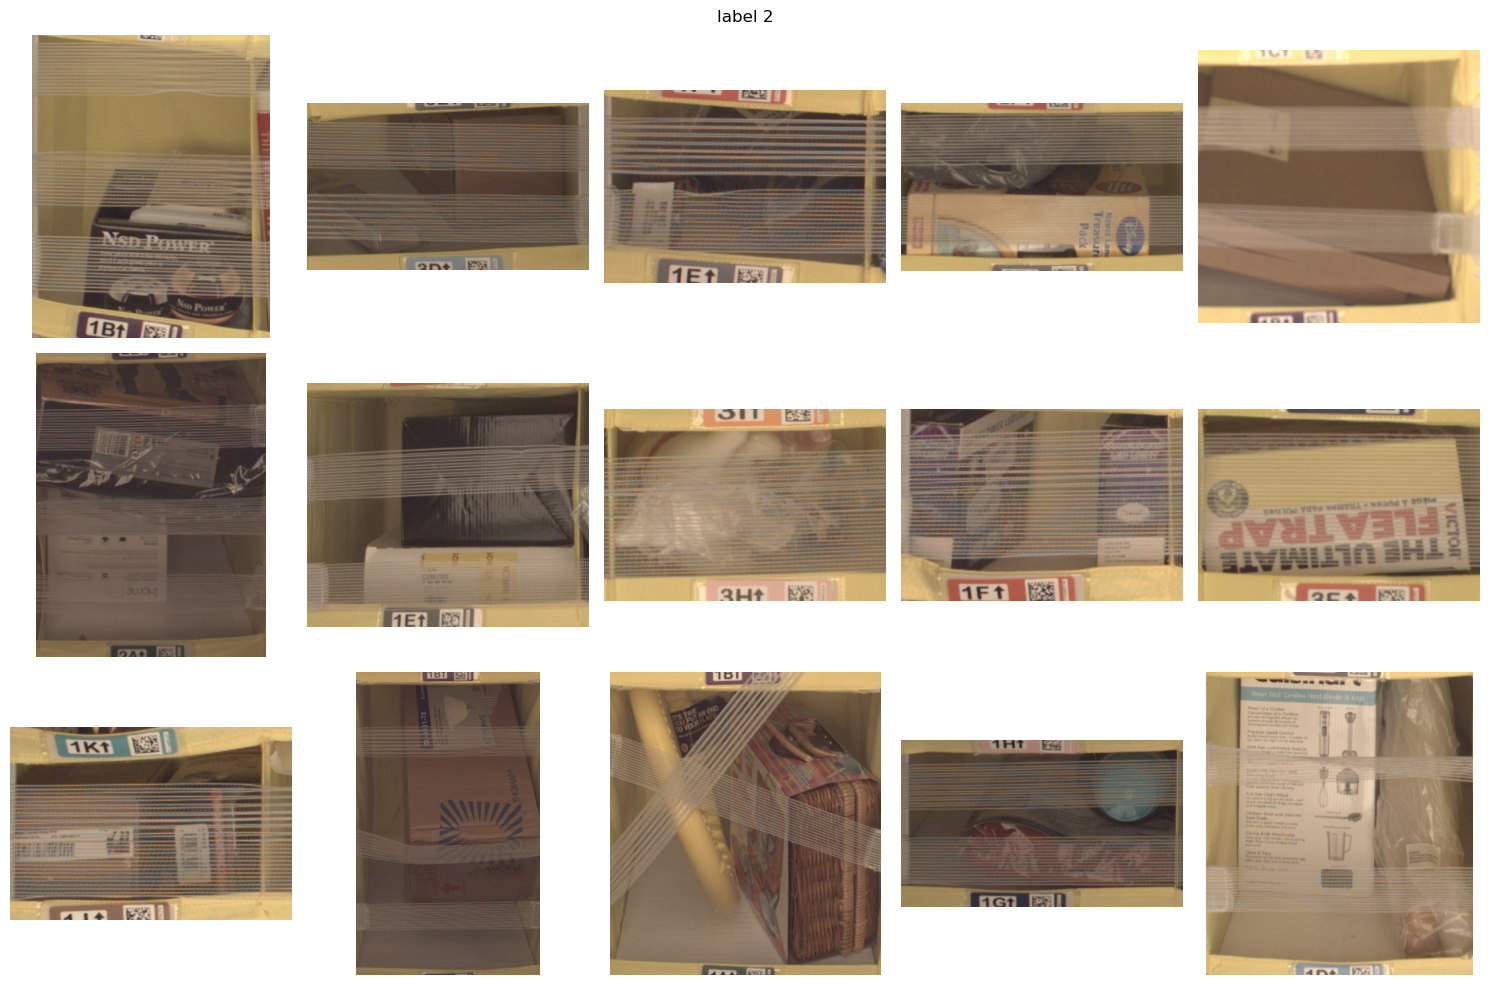

In [85]:
plot_images(data_pd,'2')

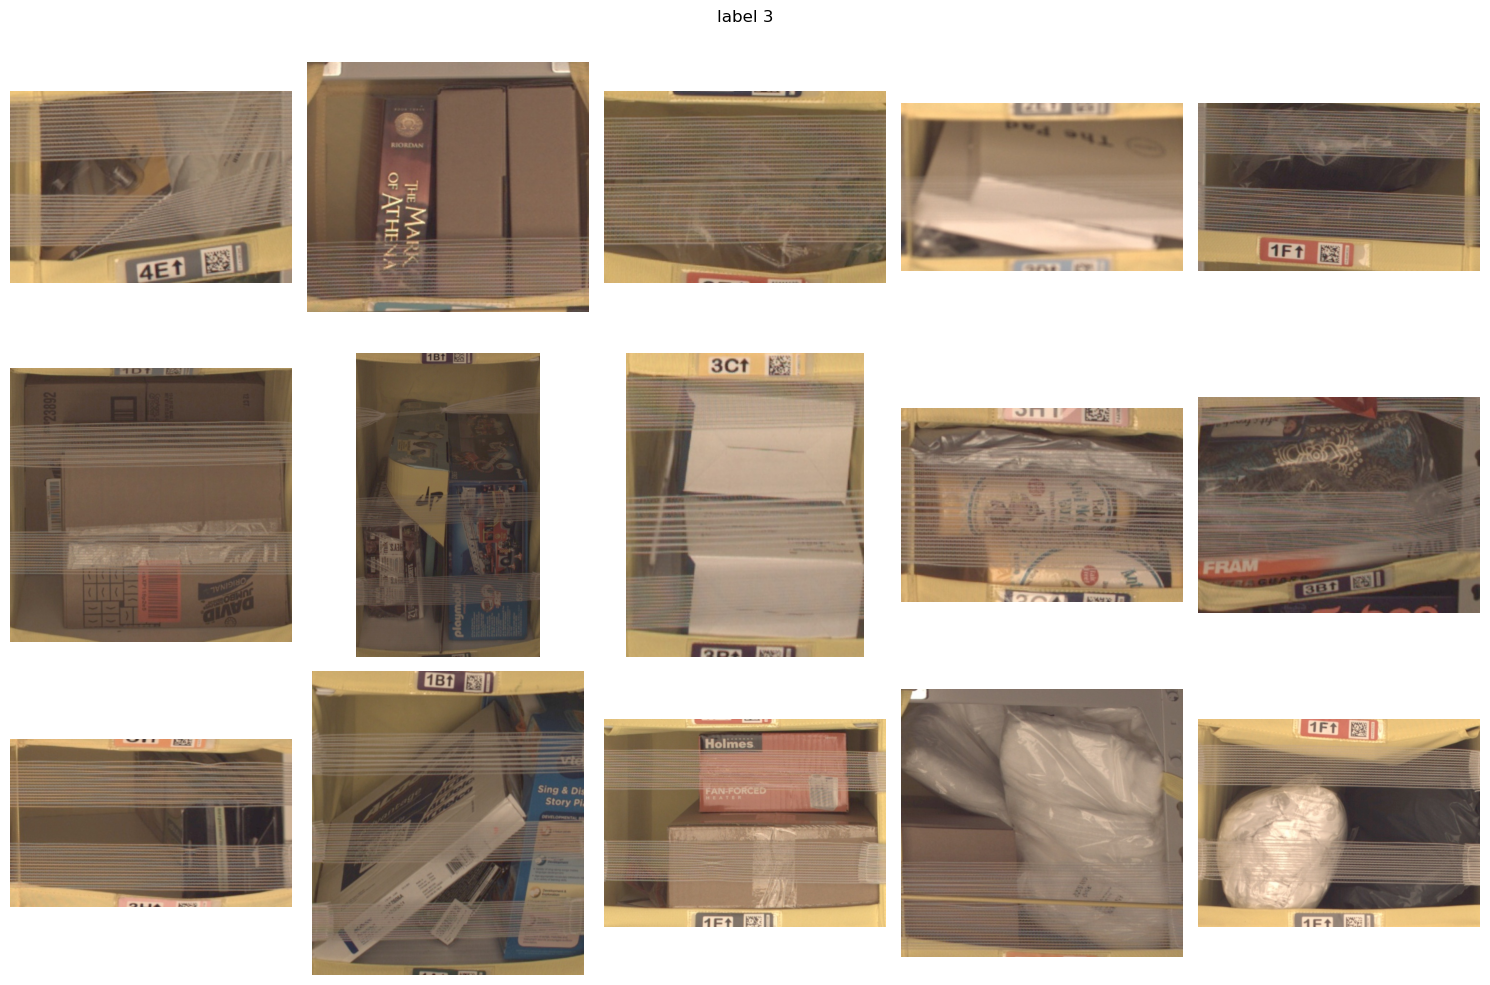

In [86]:
plot_images(data_pd,'3')

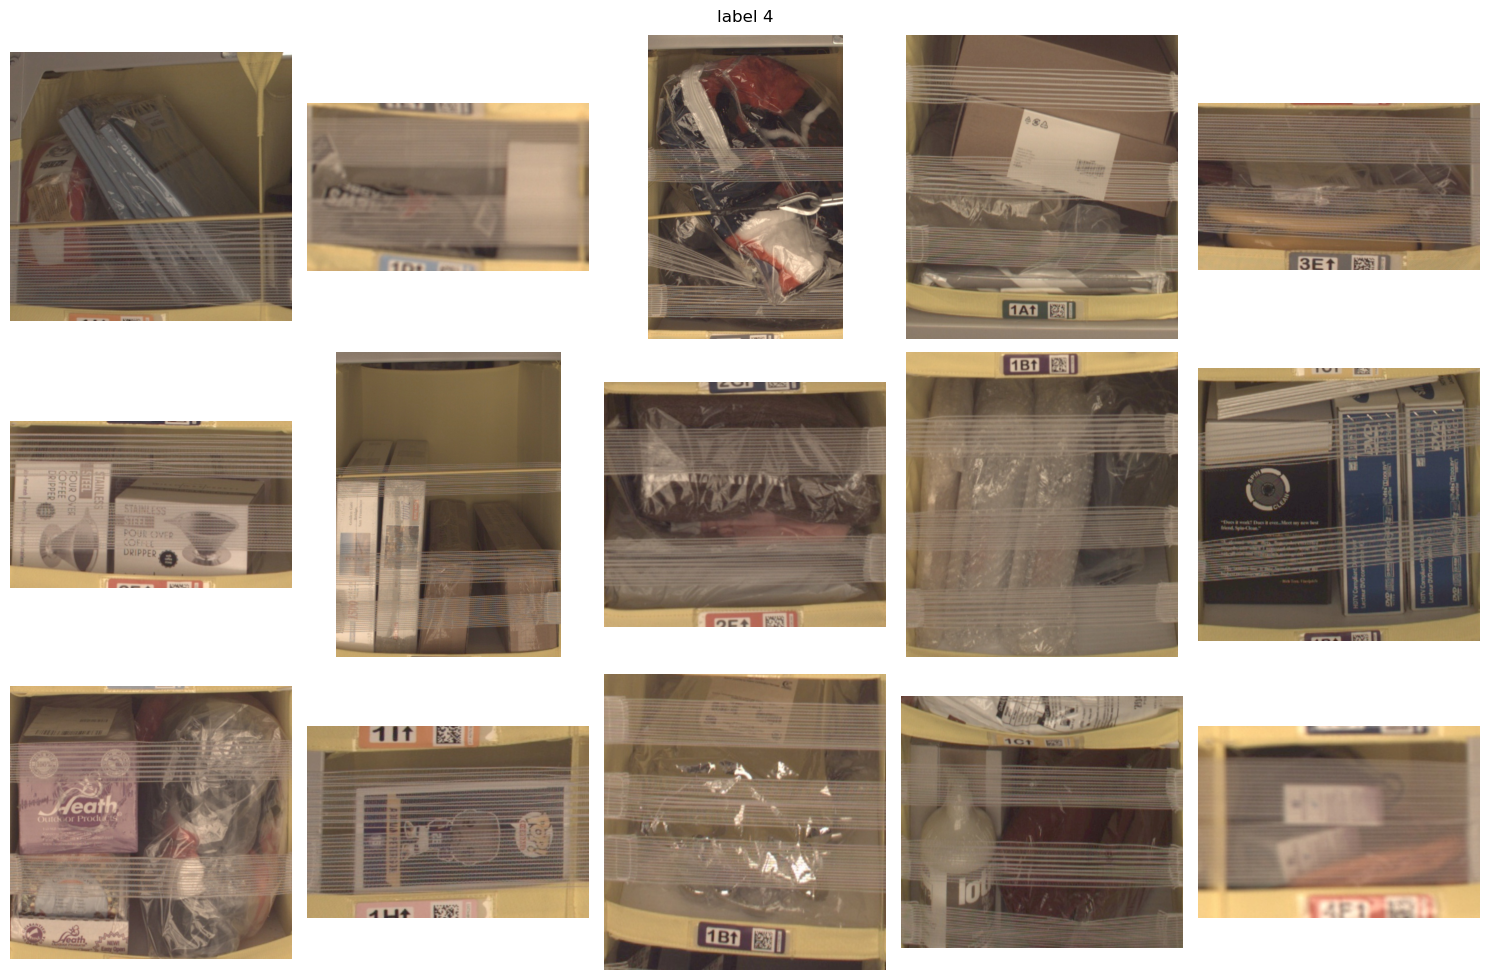

In [87]:
plot_images(data_pd,'4')

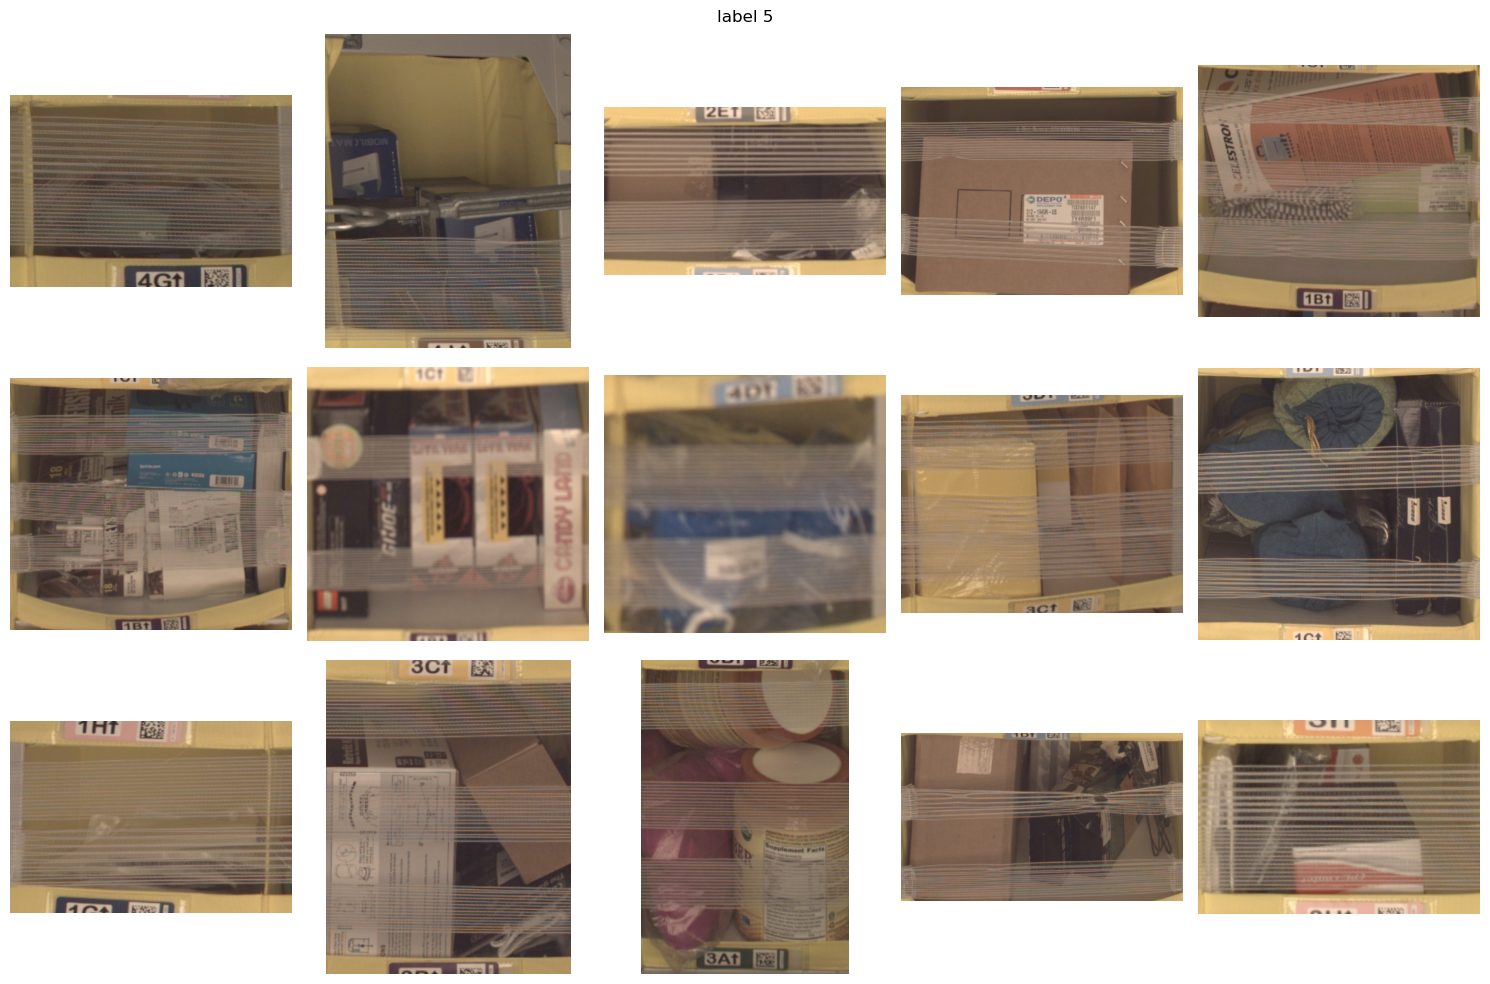

In [88]:
plot_images(data_pd,'5')

<b> Issues

* images with 3 or more items seems to be tricky to classify
* seems that some images have the incorrect label 
* there are some images that have elastic bands (to avoid items drop from the bin), this add more noise
* images with bins which have small boxes seems to be challenging

#### spliting the data

for this use case I am going to use a stratified sampling 10% for validation and testing

In [89]:
data_pd.head()

label  image_name
0     4   02573.jpg
1     4  101366.jpg
2     4   04193.jpg
3     4   07028.jpg
4     4   09521.jpg

In [100]:
sample_data = data_pd.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.2))
train_data = data_pd[~data_pd.index.isin(sample_data.index)]

test_data = sample_data.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.5))
val_data = sample_data[~sample_data.index.isin(test_data.index)]

In [105]:
train_data.shape, val_data.shape, test_data.shape

((8352, 2), (1044, 2), (1045, 2))

In [112]:
## sanity check
data_pd.shape[0] == train_data.shape[0] + val_data.shape[0] + test_data.shape[0]

True

<AxesSubplot:xlabel='label', ylabel='count'>

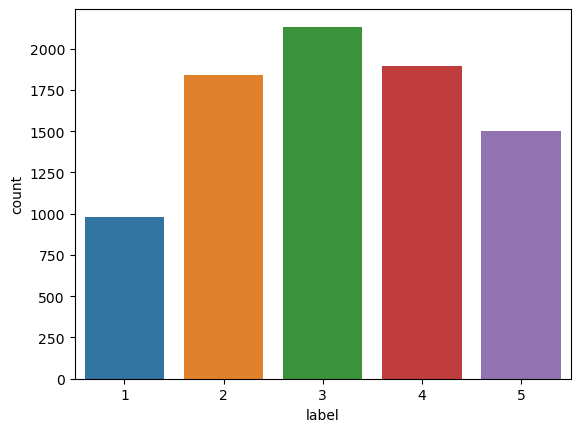

In [116]:
## sanity check
df_plot = train_data.groupby('label',as_index = False).agg(count = ('image_name','count'))
sns.barplot(data=df_plot, x="label", y="count")

<AxesSubplot:xlabel='label', ylabel='count'>

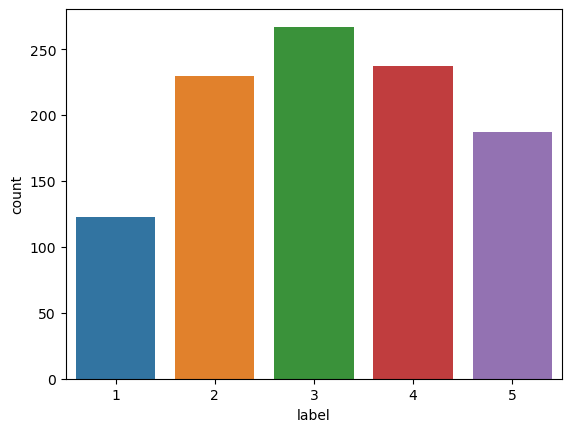

In [117]:
df_plot = val_data.groupby('label',as_index = False).agg(count = ('image_name','count'))
sns.barplot(data=df_plot, x="label", y="count")

<AxesSubplot:xlabel='label', ylabel='count'>

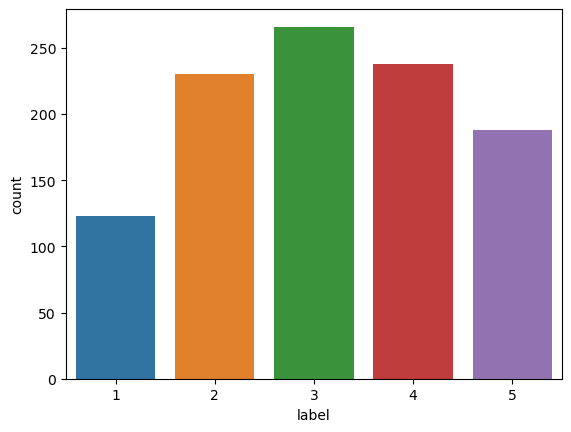

In [118]:
df_plot = test_data.groupby('label',as_index = False).agg(count = ('image_name','count'))
sns.barplot(data=df_plot, x="label", y="count")

In [121]:
print('images names are unique?', len(data_pd) == len(data_pd.image_name.unique()))

images names are unique? True


sanity checks

In [128]:
## avoid leakage
for test_image  in test_data.image_name.values:
    if test_image in val_data.image_name.values:
        print(True)

In [131]:
for train_image  in train_data.image_name.values:
    if train_image in test_data.image_name.values:
        print(True)

no leakage

<b> getting ready to upload data to S3

In [133]:
!mkdir data
!mkdir data/train
!mkdir data/validation
!mkdir data/test

mkdir: cannot create directory ‘data’: File exists


rearrange data in train/validation/test in local data folder

In [150]:
def move_data(data,folder):
    i = 0
    for index, row in data.iterrows():
        label = str(row.label)
        image_name = str(row.image_name)
        
        if not os.path.exists(f'data/{folder}/{label}'):
            os.makedirs(f'data/{folder}/{label}')
        
        shutil.move(f"train_data/{label}/{image_name}", f"data/{folder}/{label}/{image_name}")
        i+=1
        if i%100==0:
            print(f'document {i} done')


In [151]:
move_data(train_data,'train')

document 100 done
document 200 done
document 300 done
document 400 done
document 500 done
document 600 done
document 700 done
document 800 done
document 900 done
document 1000 done
document 1100 done
document 1200 done
document 1300 done
document 1400 done
document 1500 done
document 1600 done
document 1700 done
document 1800 done
document 1900 done
document 2000 done
document 2100 done
document 2200 done
document 2300 done
document 2400 done
document 2500 done
document 2600 done
document 2700 done
document 2800 done
document 2900 done
document 3000 done
document 3100 done
document 3200 done
document 3300 done
document 3400 done
document 3500 done
document 3600 done
document 3700 done
document 3800 done
document 3900 done
document 4000 done
document 4100 done
document 4200 done
document 4300 done
document 4400 done
document 4500 done
document 4600 done
document 4700 done
document 4800 done
document 4900 done
document 5000 done
document 5100 done
document 5200 done
document 5300 done
do

In [152]:
move_data(val_data,'validation')

document 100 done
document 200 done
document 300 done
document 400 done
document 500 done
document 600 done
document 700 done
document 800 done
document 900 done
document 1000 done


In [153]:
move_data(test_data,'test')

document 100 done
document 200 done
document 300 done
document 400 done
document 500 done
document 600 done
document 700 done
document 800 done
document 900 done
document 1000 done


#### Uploading data to s3

In [157]:
upload_data = False # set false to avoid re upload

if upload_data:
    s3_path_to_data = sess.upload_data(
        bucket=bucket, 
        path='data', 
        key_prefix='amazon-data'
    )

In [158]:
print('s3 data path : ',s3_path_to_data)

s3 data path :  s3://sagemaker-us-east-1-326431866350/amazon-data


## Model Training

model choice:

* finetune a pretrained model
* perform hyper parameter tunning
* trained a final model using the best parameters (profiling and debuger are in place)

### HyperParameter tunning

the parameters that are going to be assessed are:

In [8]:
s3_path_to_data = 's3://sagemaker-us-east-1-326431866350/amazon-data'

In [160]:
hyperparameter_ranges = {
    'lr': ContinuousParameter(0.001, 0.1),
    'batch_size': CategoricalParameter([16 ,32, 64]),
    'epochs': IntegerParameter(2, 6)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [161]:
estimator = PyTorch(
    entry_point = 'hpo.py',
    base_job_name = 'amazon-monitoring-model-hpo',
    estimator_name  = 'amazon-monitoring-hpo',
    role = role,
    instance_count = 4, # some more instances to see if it improves tuning training execution time
    instance_type = 'ml.m5.2xlarge', 
    py_version = 'py36',
    framework_version = '1.8'
)

tuner = HyperparameterTuner(
    estimator = estimator,
    objective_metric_name = objective_metric_name,
    hyperparameter_ranges = hyperparameter_ranges,
    metric_definitions = metric_definitions,
    max_jobs = 8,
    max_parallel_jobs = 1,
    objective_type = objective_type
)

In [162]:
%%time
tuner.fit({'train': s3_path_to_data}, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
...................................................................................................................................................................................................................................................................................................................................................................................................................................!
CPU times: user 1.8 s, sys: 212 ms, total: 2.01 s
Wall time: 35min 49s


quite good execution time results:
* 8 models
* execution time 5 minutes per model
* total execution time 35 minutes

In [163]:
best_estimator = tuner.best_estimator()

best_estimator.hyperparameters()


2023-09-04 09:48:04 Starting - Found matching resource for reuse
2023-09-04 09:48:04 Downloading - Downloading input data
2023-09-04 09:48:04 Training - Training image download completed. Training in progress.
2023-09-04 09:48:04 Uploading - Uploading generated training model
2023-09-04 09:48:04 Completed - Resource reused by training job: pytorch-training-230904-0923-006-3b3698e4


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"64"',
 'epochs': '2',
 'lr': '0.06524108473213124',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"amazon-monitoring-model-hpo-2023-09-04-09-23-01-341"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-326431866350/amazon-monitoring-model-hpo-2023-09-04-09-23-01-341/source/sourcedir.tar.gz"'}

In [168]:
best_hyperparameters ={
    'batch_size': 64,
    'epochs':2,
    'lr': 0.06524108473213124
}

### Model Training

using the best hyperparameters from the previous step, now It is possible to train the actual model

In addition debbuging and profiler are set to evaluate model training job

In [172]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, 
    framework_profile_params = FrameworkProfile(num_steps=10)
)

collection_config = [
    CollectionConfig(
        name="CrossEntropyLoss_output_0", 
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "10",
            "eval.save_interval": "1"
            }
        )
]

debugger_config = DebuggerHookConfig(collection_configs = collection_config)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [181]:
estimator = PyTorch(
    entry_point = 'train.py',
    estimator_name  = 'amazon-monitoring-hpo',
    role = role,
    instance_count=4,
    instance_type = 'ml.m5.2xlarge',
    py_version = 'py36',
    framework_version = '1.6',
    hyperparameters = best_hyperparameters,
    profiler_config = profiler_config, 
    debugger_hook_config = debugger_config, 
    rules = rules 
) 

In [182]:
%%time
estimator.fit({'train':s3_path_to_data}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-09-04-12-22-25-264


Using provided s3_resource
2023-09-04 12:22:25 Starting - Starting the training job...
2023-09-04 12:22:40 Starting - Preparing the instances for trainingVanishingGradient: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2023-09-04 12:24:18 Downloading - Downloading input data...
2023-09-04 12:24:55 Training - Downloading the training image......
2023-09-04 12:25:55 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-09-04 12:25:45,981 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-09-04 12:25:45,984 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-09-04 12:25:45,994 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-09-04 12:25:45,997 sagemaker_pytorch_container.training INFO     Invoking u

In [184]:
model_location = estimator.model_data
print(f'model location: {model_location}')

model location: s3://sagemaker-us-east-1-326431866350/pytorch-training-2023-09-04-12-22-25-264/output/model.tar.gz


benchmark model location: s3://sagemaker-us-east-1-326431866350/pytorch-training-2023-09-04-12-22-25-264/output/model.tar.gz

### Training job profiling and debugging summary

In [186]:
job_name = estimator.latest_training_job.name
client_ = estimator.sagemaker_session.sagemaker_client
rule_logs = estimator.latest_training_job.job_name + "/rule-output"
rule_output_path = estimator.output_path + rule_logs

print(f"Jobname is: {job_name}")
print(f"Client is: {client_}")
print(f'rule output location: {rule_output_path}')

Jobname is: pytorch-training-2023-09-04-12-22-25-264
Client is: <botocore.client.SageMaker object at 0x7fef94db29e0>
rule output location: s3://sagemaker-us-east-1-326431866350/pytorch-training-2023-09-04-12-22-25-264/rule-output


In [200]:
profiler_logs = estimator.latest_training_job.job_name + "/profiler-output"
profiler_output_path = estimator.output_path + profiler_logs

print(f'Profiler location: {profiler_output_path}')

Profiler location: s3://sagemaker-us-east-1-326431866350/pytorch-training-2023-09-04-12-22-25-264/profiler-output


In [243]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-326431866350/pytorch-training-2023-09-04-12-22-25-264/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-326431866350/pytorch-training-2023-09-04-12-22-25-264/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-326431866350/pytorch-training-2023-09-04-12-22-25-264/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-326431866350/pytorch-training-2023-09-04-12-22-25-264/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-326

In [244]:
# ! aws s3 cp {profiler_output_path} ./ --recursive

In [ ]:
IPython.display.HTML(filename="ProfilerReport/profiler-output/profiler-report.html")

## Standout Suggestions


* the training time took about 1 hour, it was a lot and the diagnosis will be done in the following section
* the model have still not strong results, either test new architectures or other parameters

### Model Profiling and Debugging

According to the profiling notebook, the total training a big share of the processing was spent in other taskes and no training and validation

<img src="screenshots/time_by_task_type.jpg">

in the training time, the time was spent mainly in training the convolutions

<img src="screenshots/cpu_operators.jpg">

Is there some anomalous behaviour in your debugging output? 

yes, it was 'PoorWeightInitialization: IssuesFound' -> to solve this issue there are two options:
* re run the model
* initialize weights https://pytorch.org/docs/stable/nn.init.html

### Model Deploying and Querying


In [9]:
model_location = 's3://sagemaker-us-east-1-326431866350/pytorch-training-2023-09-04-12-22-25-264/output/model.tar.gz'

In [10]:
## this helper configurations help to deploy the model in a more friendly manner (at least to read other jpg files)
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImgPredictor(sagemaker_predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super(ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel(
    model_data = model_location,
    role = role,

    entry_point= "inference.py",
    py_version = "py36",
    framework_version = "1.6",
    predictor_cls = ImgPredictor
)

predictor_baseline = pytorch_model.deploy(initial_instance_count = 1, instance_type = "ml.m5.2xlarge", endpoint_name = 'monitoring-model-baseline')

-----!

In [13]:
model_location_alt = 's3://sagemaker-us-east-1-326431866350/pytorch-training-2023-09-05-19-26-00-650/output/model.tar.gz'

In [14]:
## this helper configurations help to deploy the model in a more friendly manner (at least to read other jpg files)
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImgPredictor(sagemaker_predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super(ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel(
    model_data = model_location_alt,
    role = role,

    entry_point= "inference_alt.py",
    py_version = "py36",
    framework_version = "1.6",
    predictor_cls = ImgPredictor
)

predictor_alternative = pytorch_model.deploy(initial_instance_count = 1, instance_type = "ml.m5.2xlarge", endpoint_name = 'monitoring-model-alternative')

----!

#### Testing end using Test data from s3

In [16]:
test_images_jpgs = list()
s3 = boto3.resource('s3', region_name='us-east-1') 
s3_bucket = s3.Bucket(bucket) 
for my_bucket_object in s3_bucket.objects.filter(Prefix='amazon-data/test'):
    key = my_bucket_object.key
    test_images_jpgs.append(key)

In [55]:
random.shuffle(test_images_jpgs)
n_sample = 1000
sample_images = test_images_jpgs[0:n_sample]

In [56]:
# print('sample images to test: ',sample_images)

In [57]:
display_image = False
results_df = {
    'label' :list(),
    'baseline_predition': list(),
    'alternative_prediction':list(),
}

for i,sample_jpg in enumerate(sample_images):
    label = sample_jpg.split('/')[2]
    data_location = 's3://{}/{}'.format(bucket, sample_jpg) 
    s3.Bucket(bucket).download_file(sample_jpg, 'tmp_image.jpg')
    with open('tmp_image.jpg' , "rb") as f:

        payload = f.read()
        response_baseline = predictor_baseline.predict(payload, initial_args={"ContentType": "image/jpeg"})
        response_alternative = predictor_alternative.predict(payload, initial_args={"ContentType": "image/jpeg"})
        predicted_n_items_baseline = np.argmax(response_baseline, 1) + 1
        predicted_n_items_alternative = np.argmax(response_alternative, 1) + 1
        predicted_n_items_baseline = predicted_n_items_baseline[0]
        predicted_n_items_alternative = predicted_n_items_alternative[0]
        
        results_df['label'].append(label)
        results_df['baseline_predition'].append(predicted_n_items_baseline)
        results_df['alternative_prediction'].append(predicted_n_items_alternative)
        
        if display_image:
            print('--------------------------------------------------------')
            print('the test image is:')
            display(Image.open(io.BytesIO(payload)))
            print('results are:')
            print(f"prediceted class baseline: {predicted_n_items_baseline}")
            print(f"prediceted class alternative: {predicted_n_items_alternative}")
            print(f"true label is: {label}")
results_df = pd.DataFrame(results_df)

In [64]:
results_df.shape

(1000, 3)

In [67]:
sampling = {'baseline':list(), 'alternative':list()}
for i in range(100):
    df = results_df.sample(n = 20).copy()
    acc_base = accuracy_score(df['label'].astype(int), df['baseline_predition'].astype(int))
    acc_alt = accuracy_score(df['label'].astype(int), df['alternative_prediction'].astype(int))
    sampling['baseline'].append(acc_base)
    sampling['alternative'].append(acc_alt)
    del df
sampling = pd.DataFrame(sampling)

In [70]:
melt_df = sampling.melt(value_vars=['baseline','alternative'],var_name='model', value_name='accuracy')

<AxesSubplot:xlabel='accuracy', ylabel='Count'>

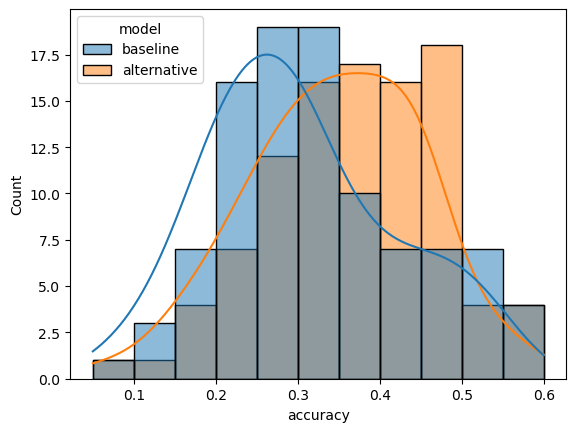

In [72]:
sns.histplot(data=melt_df, x="accuracy",hue = 'model', kde=True)

In [75]:
results_df.head()

label  baseline_predition  alternative_prediction
0     3                   3                       4
1     4                   3                       5
2     2                   2                       4
3     5                   3                       3
4     5                   3                       4

In [80]:
mean_b = sampling['alternative'].mean()
std_b = sampling['alternative'].std()

print(f'mean: {mean_b}')
print(f'std: {std_b}')

mean: 0.3465
std: 0.10642372903168779


In [84]:
res = ttest_ind(sampling['alternative'], sampling['baseline'], equal_var=True)

In [85]:
res

Ttest_indResult(statistic=2.8282449956995395, pvalue=0.005161669093099475)

In [73]:
accuracy_score(results_df['label'].astype(int), results_df['baseline_predition'].astype(int))

0.313

In [74]:
accuracy_score(results_df['label'].astype(int), results_df['alternative_prediction'].astype(int))

0.323

In [248]:
shutdown_end_point = False

if shutdown_end_point:
    predictor.delete_endpoint()